In [1]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFR
import json
import random
import pickle

In [2]:
client = MongoClient()

In [3]:
db = client.precog_fb_data

In [4]:
events = db.events
cursor = events.find({})
all_events = []
for event in cursor:
    all_events.append(event) 

In [5]:
len(all_events)

1043

In [6]:
json_data = all_events

In [7]:
remove_col = ['owner', 'timezone', '_id', 'id', 'is_page_owned', 'is_canceled', 'can_viewer_post', 'declined_count', 'description', 'start_time', 'is_draft', 'parent_group', 'is_viewer_admin', 'name', 'cover', 'place', 'end_time', 'updated_time', 'ticket_uri', 'ticketing_privacy_uri', 'ticketing_terms_uri', 'type']

In [8]:
for item in remove_col:
    for event in json_data:
        event.pop(item, None)

In [9]:
import sys
json.dump(json_data[4], sys.stdout)

{"noreply_count": 3026, "category": "food", "attending_count": 3739, "can_guests_invite": true, "interested_count": 9787, "guest_list_enabled": true, "maybe_count": 9787}

In [10]:
df = pd.io.json.json_normalize(json_data)

In [11]:
df.columns = df.columns.map(lambda x: x.split(".")[-1])

In [12]:
ds = df

In [13]:
ds.head()

,attending_count,can_guests_invite,category,guest_list_enabled,interested_count,maybe_count,noreply_count
0,644,True,food,True,5582,5582,531
1,846,True,food,True,4293,4293,943
2,835,True,food,True,4031,4031,5126
3,2232,True,food,True,3858,3858,1337
4,3739,True,food,True,9787,9787,3026


In [14]:
for col in ds.columns:
    print col

attending_count
can_guests_invite
category
guest_list_enabled
interested_count
maybe_count
noreply_count


In [15]:
np.unique(ds['category'], return_counts=True)

(array([u'art', u'education', u'food', u'music', u'travel'], dtype=object),
 array([225, 171, 221, 222, 204]))

In [16]:
cat_to_int = {'art': 1, 'education': 2, 'food': 3, 'music': 4, 'travel': 5}
ds['category'] = ds['category'].map(cat_to_int)
print np.unique(ds['category'], return_counts=True)

(array([1, 2, 3, 4, 5]), array([225, 171, 221, 222, 204]))


In [17]:
ds.corr()

,attending_count,can_guests_invite,category,guest_list_enabled,interested_count,maybe_count,noreply_count
attending_count,1.000000,-0.116105,-0.022953,0.042121,0.587304,0.587304,0.275097
can_guests_invite,-0.116105,1.000000,-0.008454,-0.008872,-0.014266,-0.014266,-0.020965
category,-0.022953,-0.008454,1.000000,-0.016870,-0.032221,-0.032221,0.012845
guest_list_enabled,0.042121,-0.008872,-0.016870,1.000000,0.060650,0.060650,0.022309
interested_count,0.587304,-0.014266,-0.032221,0.060650,1.000000,1.000000,0.153942
maybe_count,0.587304,-0.014266,-0.032221,0.060650,1.000000,1.000000,0.153942
noreply_count,0.275097,-0.020965,0.012845,0.022309,0.153942,0.153942,1.000000


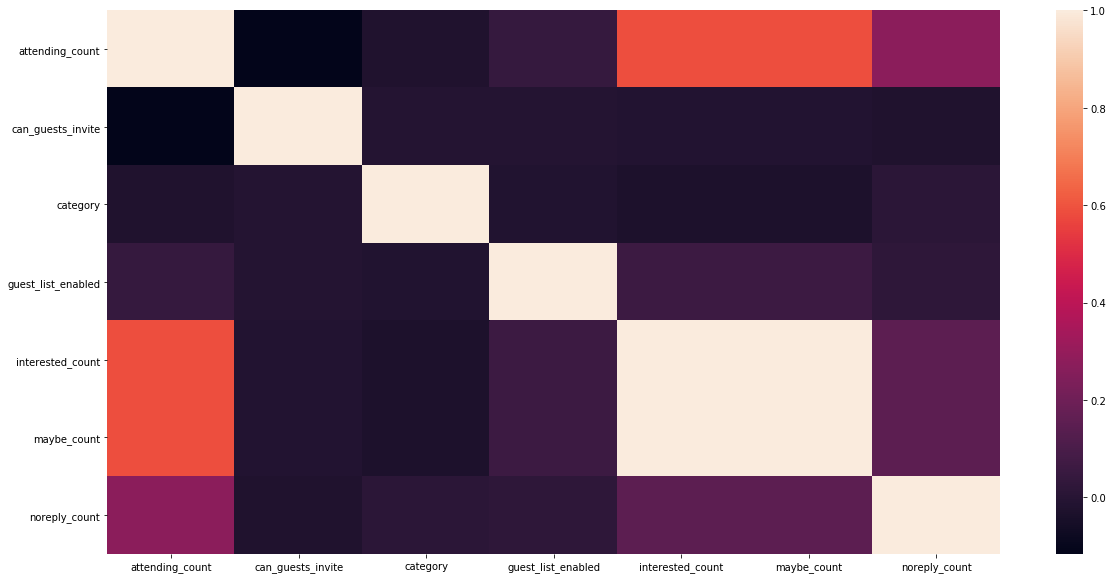

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(ds.corr())

In [19]:
label = ds['interested_count']
data = ds
del data['interested_count']
del data['category']

In [20]:
label.head()

0    5582
1    4293
2    4031
3    3858
4    9787
Name: interested_count, dtype: int64

In [21]:
data.head()

,attending_count,can_guests_invite,guest_list_enabled,maybe_count,noreply_count
0,644,True,True,5582,531
1,846,True,True,4293,943
2,835,True,True,4031,5126
3,2232,True,True,3858,1337
4,3739,True,True,9787,3026


In [22]:
data = np.asarray(data)
label = np.asarray(label)

In [23]:
print 'Data Shape: ',  data.shape
print 'Label Shape: ', label.shape

Data Shape:  (1043, 5)
Label Shape:  (1043,)


In [24]:
split = int(0.75*data.shape[0])
X_train = data[:split, :]
y_train = label[:split]

X_test = data[split:, :]
y_test = label[split:]

print "Training Dataset: ", X_train.shape
print "Training Labels:  ",  y_train.shape
print "Testing Dataset:  ",  X_test.shape
print "Testing Labels:   ",   y_test.shape

Training Dataset:  (782, 5)
Training Labels:   (782,)
Testing Dataset:   (261, 5)
Testing Labels:    (261,)


In [25]:
rf = RFR(n_estimators=200, n_jobs=-1)

rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
pickle.dump(rf ,open('classifier.pkl', 'wb'),protocol=2)

In [26]:
col_int_list = []
for col in ds.columns:
    col_int_list.append(col)
col_int_list

[u'attending_count',
 u'can_guests_invite',
 u'category',
 u'guest_list_enabled',
 u'maybe_count',
 u'noreply_count']

In [27]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s => (%f)" % (f + 1, indices[f], col_int_list[indices[f]] , importances[indices[f]]))

Feature ranking:
1. feature 4 - maybe_count => (0.995014)
2. feature 5 - noreply_count => (0.003644)
3. feature 0 - attending_count => (0.001003)
4. feature 2 - category => (0.000323)
5. feature 1 - can_guests_invite => (0.000016)
6. feature 3 - guest_list_enabled => (0.000000)


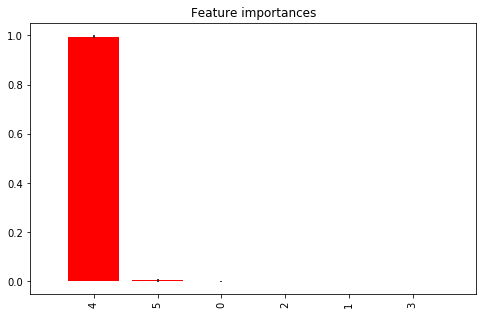

In [28]:
# Plot the feature importances of the forest
plt.figure(figsize=(8,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [29]:
true_values = []
predicted_values = []
for ix in random.sample(range(0,261), 50):
    predicted_values.append(int(rf.predict([X_test[ix]])[0]))
    true_values.append(y_test[ix])

In [30]:
for ix in range(5):
    print predicted_values[ix], true_values[ix]

4582 4589
4443 4442
2583 2556
10234 10241
9244 9248


In [26]:
print rf.score(X_test, y_test)*100

98.797991358


In [32]:
[u'attending_count',
 u'can_guests_invite',
 u'category',
 u'guest_list_enabled',
 u'maybe_count',
 u'noreply_count']

[u'attending_count',
 u'can_guests_invite',
 u'category',
 u'guest_list_enabled',
 u'maybe_count',
 u'noreply_count']

In [33]:
X_test[0]

array([4, True, 2, True, 99, 0], dtype=object)

In [34]:
t = [1394, True, 4, True, 11204, 417]

In [35]:
int(rf.predict([t]))

11168

In [36]:
X2_train = np.delete(X_train, [2,4], axis=1)
X2_test = np.delete(X_test, [2,4], axis=1)

In [37]:
print X2_train.shape, X2_test.shape

(782, 4) (261, 4)


In [38]:
for ix in range(1,2000, 100):
    for iy in range(1,20, 2):
        rf2 = RFR(n_estimators=ix, n_jobs=-1, max_depth=iy)
        rf2.fit(X2_train, y_train)
        print ix, iy, "=>", rf2.score(X2_test,y_test)*100

1 1 => 15.6704872282
1 3 => 22.6793582268
1 5 => 21.7327037917
1 7 => 3.50003507875
1 9 => 8.52414248976
1 11 => -0.99561072893
1 13 => -19.2653127225
1 15 => 3.49560269866
1 17 => -58.9722028884
1 19 => 14.3892702638
101 1 => 37.7546906574
101 3 => 41.4859842146
101 5 => 44.865710908
101 7 => 44.7555000938
101 9 => 43.4787664958
101 11 => 43.5305745934
101 13 => 41.0119573776
101 15 => 38.0041395952
101 17 => 40.9382880406
101 19 => 38.6299375198
201 1 => 37.8822018396
201 3 => 43.1987837022
201 5 => 44.1010243065
201 7 => 44.1925629792
201 9 => 41.2820785006
201 11 => 42.1841314844
201 13 => 40.9032041339
201 15 => 40.3246739882
201 17 => 41.8306169755
201 19 => 41.3263549332
301 1 => 36.3958585985
301 3 => 43.776313842
301 5 => 44.0635856908
301 7 => 44.9997266262
301 9 => 43.4072438588
301 11 => 42.4026938495
301 13 => 41.9089931916
301 15 => 40.8822698416
301 17 => 41.5138167286
301 19 => 40.1387113272
401 1 => 36.9654117091
401 3 => 43.0746174871
401 5 => 44.456784518
401 7 => 43

In [42]:
t2 = [1394, True, True, 417]
rf2.predict([t2])

array([ 7315.42200604])

In [43]:
importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_train.shape[1]):
    print("%d. feature %d => (%f)" % (f + 1, indices[f] , importances[indices[f]]))

Feature ranking:
1. feature 0 => (0.745800)
2. feature 3 => (0.248395)
3. feature 1 => (0.005707)
4. feature 2 => (0.000098)
